In [11]:
import sys
sys.path.append('/Users/constantinpierer/Documents/TU_Wien/Technische_Mathematik/7.Semester/Repositorys/myASC-ODE/mechsystem')
sys.path.append('../build/mechsystem')

from mass_spring import *
from pythreejs import *

import numpy as np
import matplotlib.pyplot as plt
from time import sleep

In [12]:
mss = MassSpringSystem3d()
mss.gravity = (0, 0, -9.81)

# Base (fixed)
base = mss.add(Fix((0, 0, 0)))

# anti weight
second_base = mss.add(Fix((-2, 0, 0)))

# Tower masses
tower_bottom = mss.add(Mass(0.5, (0, 0, 2), (0, 0, 0)))
tower_top = mss.add(Mass(0.1, (0, 0, 4), (0, 0, 0)))

# Boom masses
boom_mid = mss.add(Mass(0.1, (2, 0, 4), (0, 0, 0)))
boom_end = mss.add(Mass(0.1, (4, 0, 4), (0, 0, 0)))

# Load mass
load = mss.add(Mass(0.001, (4, 0, 2), (0, 0, 0)))

# Tower joints
mss.add(Joint(2.0, (base, tower_bottom)))
mss.add(Joint(2.0, (tower_bottom, tower_top)))

# Anti-mass joint
mss.add(Joint(np.sqrt(8), (second_base, tower_bottom)))
mss.add(Joint(np.sqrt(20), (second_base, tower_top)))
#mss.add(Joint(2.0, (anti_mass, base)))

# additional diagonal joints
mss.add(Joint(np.sqrt(8), (tower_bottom, boom_mid)))
mss.add(Joint(np.sqrt(20), (tower_bottom, boom_end)))

# Boom joints
mss.add(Joint(2.0, (tower_top, boom_mid)))
mss.add(Joint(2.0, (boom_mid, boom_end)))


mss.add(Spring(100.0, 2.0, (boom_end, load))) 


0

In [13]:

masses = []
for i, m in enumerate(mss.masses):
    if i < 2:  
        color = 'blue'
        size = 0.1
    elif i < 4:  
        color = 'orange'
        size = 0.08
    else:  
        color = 'red'
        size = 0.15
        
    masses.append(
        Mesh(SphereBufferGeometry(size, 16, 16),
             MeshStandardMaterial(color=color),
             position=(m.pos[0], m.pos[1], m.pos[2])))

# Fixed points
fixes = []
for f in mss.fixes:
    fixes.append(
        Mesh(SphereBufferGeometry(0.2, 16, 16),
             MeshStandardMaterial(color='black'),
             position=(f.pos[0], f.pos[1], f.pos[2])))

# Joints (rigid beams)
jointpos = []
for j in mss.joints:
    pA = mss[j.connectors[0]].pos
    pB = mss[j.connectors[1]].pos
    jointpos.append([[pA[0], pA[1], pA[2]], [pB[0], pB[1], pB[2]]])

joints = None
if jointpos:
    jointgeo = LineSegmentsGeometry(positions=jointpos)
    beam_material = LineMaterial(linewidth=3, color='gray')
    joints = LineSegments2(jointgeo, beam_material)

# Springs (more or less a flexible cables)
springpos = []
for s in mss.springs:
    pA = mss[s.connectors[0]].pos
    pB = mss[s.connectors[1]].pos
    springpos.append([[pA[0], pA[1], pA[2]], [pB[0], pB[1], pB[2]]])

springs = None
if springpos:
    springgeo = LineSegmentsGeometry(positions=springpos)
    spring_material = LineMaterial(linewidth=4, color='green')
    springs = LineSegments2(springgeo, spring_material)

axes = AxesHelper(2)


In [14]:
view_width = 800
view_height = 600


camera = PerspectiveCamera(position=[8, 6, 8], aspect=view_width/view_height)
key_light = DirectionalLight(position=[5, 10, 5], intensity=1.0)
ambient_light = AmbientLight(intensity=0.5)

scene_objects = [*masses, *fixes, axes, camera, key_light, ambient_light]
if joints:
    scene_objects.append(joints)
if springs:
    scene_objects.append(springs)

scene = Scene(children=scene_objects)
controller = OrbitControls(controlling=camera)
renderer = Renderer(camera=camera, scene=scene, controls=[controller], width=view_width, height=view_height)


renderer

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, position=(8.0, 6.0, 8.0), projectionMatrix=(1.0, …

In [17]:


load_positions = []
time_steps = []

for i in range(100):
    try:

        mss.simulate(0.01, 100)  
        
        
        for m, mvis in zip(mss.masses, masses):
            mvis.position = (m.pos[0], m.pos[1], m.pos[2])

   
        if joints:
            jointpos = []
            for j in mss.joints:
                pA = mss[j.connectors[0]].pos
                pB = mss[j.connectors[1]].pos
                jointpos.append([[pA[0], pA[1], pA[2]], [pB[0], pB[1], pB[2]]])
            joints.geometry = LineSegmentsGeometry(positions=jointpos)


        if springs:
            springpos = []
            for s in mss.springs:
                pA = mss[s.connectors[0]].pos
                pB = mss[s.connectors[1]].pos
                springpos.append([[pA[0], pA[1], pA[2]], [pB[0], pB[1], pB[2]]])
            springs.geometry = LineSegmentsGeometry(positions=springpos)

        load_pos = mss.masses[-1].pos
        load_positions.append([load_pos[0], load_pos[1], load_pos[2]])
        time_steps.append(i * 0.01)
        
     
        if i % 10 == 0:
            print(f"Step {i}: Load at ({load_pos[0]:.2f}, {load_pos[1]:.2f}, {load_pos[2]:.2f})")
        
        sleep(0.1) 
        
    except Exception as e:
        print(f'Error at step {i}: {e}')
        break



Step 0: Load at (4.00, 0.00, -59.21)
Step 10: Load at (4.00, 0.00, -16.53)
Step 10: Load at (4.00, 0.00, -16.53)
Step 20: Load at (4.00, 0.00, -170.62)
Step 20: Load at (4.00, 0.00, -170.62)
Step 30: Load at (4.00, 0.00, -139.97)
Step 30: Load at (4.00, 0.00, -139.97)
Step 40: Load at (4.00, 0.00, -0.47)
Step 40: Load at (4.00, 0.00, -0.47)
Step 50: Load at (4.00, 0.00, -97.51)
Step 50: Load at (4.00, 0.00, -97.51)
Step 60: Load at (4.00, 0.00, -190.83)
Step 60: Load at (4.00, 0.00, -190.83)
Step 70: Load at (4.00, 0.00, -49.37)
Step 70: Load at (4.00, 0.00, -49.37)
Step 80: Load at (4.00, 0.00, -23.38)
Step 80: Load at (4.00, 0.00, -23.38)
Step 90: Load at (4.00, 0.00, -177.20)
Step 90: Load at (4.00, 0.00, -177.20)


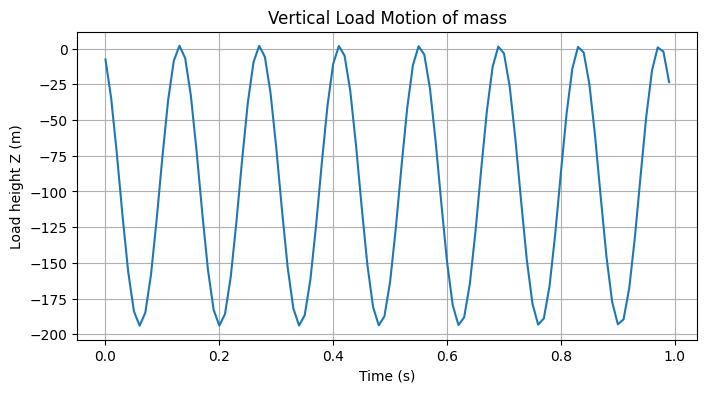

In [16]:

if len(load_positions) < 10:
    print("Not enough data for analysis")
else:
    load_pos = np.array(load_positions)
    time = np.array(time_steps)

    z = load_pos[:, 2]

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(time, z)
    plt.xlabel("Time (s)")
    plt.ylabel("Load height Z (m)")
    plt.title("Vertical Load Motion of mass")
    plt.grid(True)
    plt.show()
